# Notebook for width analysis of braided rivers processing in low-flow

In [35]:
import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio import shutil as rio_shutil
from rasterio.warp import transform
from skimage.morphology import label, binary_dilation


# append braidedSP directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'braidedSP')))
import procBraided as pc
import tools as skel
import mask
import datetime

import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point, LineString
from shapely.ops import transform
import pyproj
from functools import partial
from scipy.spatial import cKDTree


In [ ]:
def reproject_to_latlon(geotiff_path, array):

    """
    Reprojects a GeoTIFF-associated array from its native CRS to WGS84 (lat/lon).
    
    Parameters:
        geotiff_path (str): Path to the original GeoTIFF with georeferencing.
        array (np.ndarray): The image data array (same shape as the GeoTIFF).
    
    Returns:
        lat_grid (np.ndarray): 2D array of latitudes
        lon_grid (np.ndarray): 2D array of longitudes
        array (np.ndarray): Original input array (unchanged)
    """
    with rasterio.open(geotiff_path) as src:
        transform_affine = src.transform
        crs = src.crs
        height, width = src.height, src.width

        # Create row/column grid
        rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

        # Convert row/col to x/y coordinates
        xs, ys = rasterio.transform.xy(transform_affine, rows, cols)

        # Flatten x/y to transform to lat/lon
        xs_flat = np.array(xs).flatten()
        ys_flat = np.array(ys).flatten()

        # Transform coordinates to lat/lon (EPSG:4326)
        lon_flat, lat_flat = transform(crs, "EPSG:4326", xs_flat, ys_flat)

        # Reshape to original image shape
        lon_grid = np.array(lon_flat).reshape((height, width))
        lat_grid = np.array(lat_flat).reshape((height, width))

    return lat_grid, lon_grid, array



Text(0.5, 1.0, 'Processed Water Mask')

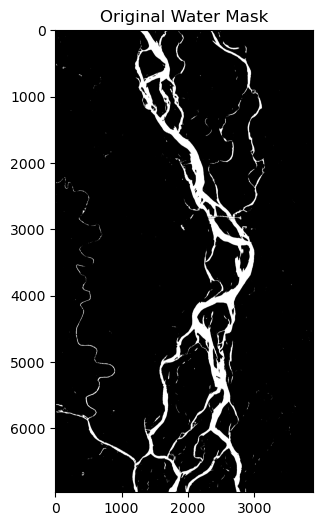

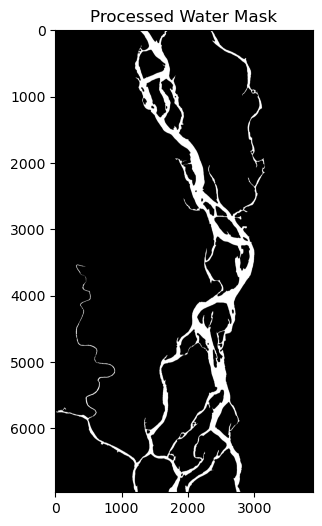

In [3]:
# Load in the water mask and plot
water_mask = mask.Mask(river_name='brahmaputra',date=datetime.datetime(2024, 2, 3), path=r'..\data\brahmaputra\S2\S2_WaterMask_NDWI_0224.tif', odir=r'..\data\brahmaputra\masks')
water_mask.process(save_progress=True)

fig, ax = plt.subplots(figsize=(4, 6))
ax.imshow(water_mask.array,cmap=plt.cm.gray)
ax.set_title('Original Water Mask')

fig, ax = plt.subplots(figsize=(4, 6))
ax.imshow(water_mask.smoothed,cmap=plt.cm.gray)
ax.set_title('Processed Water Mask')

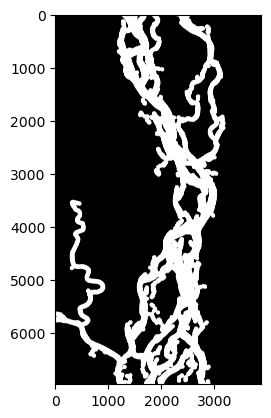

In [ ]:
# Very Dilated version of the water mask ( for reducing the PIXC data size without affecting the width estimation )

dilated_mask = binary_dilation(water_mask.array, footprint=skel.createKernel(40)) # OG 10
labeled_mask, num_features = label(dilated_mask, return_num=True)
component_sizes = np.bincount(labeled_mask.ravel())
component_sizes[0] = 0
oversmoothed_mask = (labeled_mask == component_sizes.argmax())
plt.imshow(oversmoothed_mask,cmap=plt.cm.gray)

# Write to file
original_tif = r'..\data\brahmaputra\S2\S2_WaterMask_NDWI_0224.tif'  # Has desired metadata
output_oversmoothed_mask_tiff = r'..\data\brahmaputra\masks\figs\brahmaputra_2024-02-03_oversmoothed_mask.tif'

# Load the original to get metadata
with rasterio.open(original_tif) as src:
    meta = src.meta.copy()

# Write the new GeoTIFF using the copied metadata
with rasterio.open(output_oversmoothed_mask_tiff, 'w', **meta) as dst:
    dst.write(oversmoothed_mask, 1)  # 1 = write to band 1


No centerline buffer to trim to.


<Axes: >

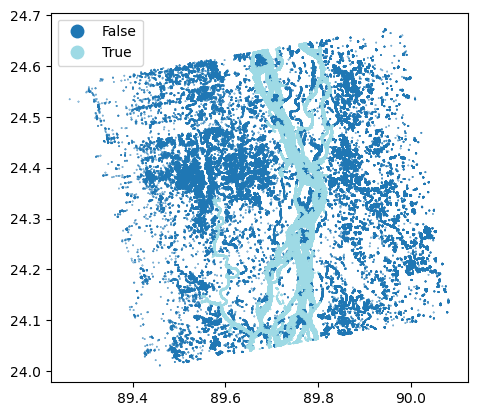

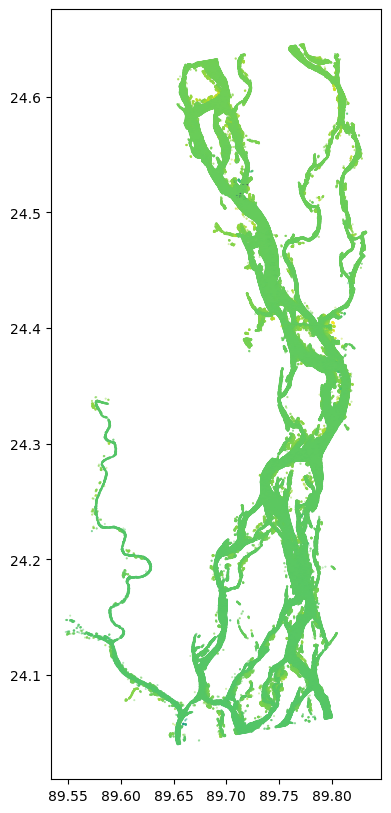

In [ ]:
# Import original SWOT tile for 02-2024
pixc_file = r"..\data\brahmaputra\PIXC\SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc"
pixc = pc.readPIXC(pixc_file,[])
pixcdate = os.path.basename(pixc_file)[29:37]

# Import SWOT braided channel product for 02-2024
braided_gdf = gpd.read_file(r"..\odir\258_112L\0224_generated_cl.geojson")

# Trim PIXC to a dilated version of the water mask - removes the excess data dar from the river for processing but does not affect width estimation
trimmed_gdf, pixc_gdf = pc.trim2mask_general(pixc,oversmoothed_mask,output_oversmoothed_mask_tiff) # Trimming to largest component mask

# plot the trimmed PIXC
fig, ax = plt.subplots(figsize=(10, 10))
trimmed_gdf.plot(ax=ax, column='heightEGM', alpha=0.5, label='Trimmed PIXC',s=0.2)

<Axes: xlabel='Longitude', ylabel='Latitude'>

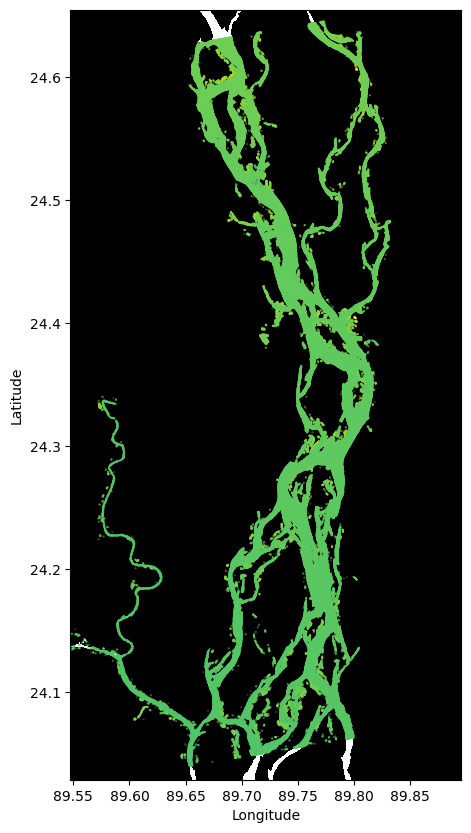

In [ ]:
# Compare original SWOT open water classified pixels with S2 mask (visual inspection)
# Reproject mask to lat/lon
tiff_path = r"..\data\brahmaputra\masks\figs\brahmaputra_2024-02-03_smoothed_mask.tif"

with rasterio.open(tiff_path) as src:
    data = src.read(1)  # Read first band

lat, lon, _ = reproject_to_latlon(tiff_path, data)

fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(lon, lat, data, shading='auto', cmap='gray')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
trimmed_gdf.plot(ax=ax, column='heightEGM', alpha=0.5, label='Trimmed PIXC',s=0.1)

# See how the processed SWOT braided widths compare to the widths from the S2 mask - using transect analysis

<Axes: xlabel='Longitude', ylabel='Latitude'>

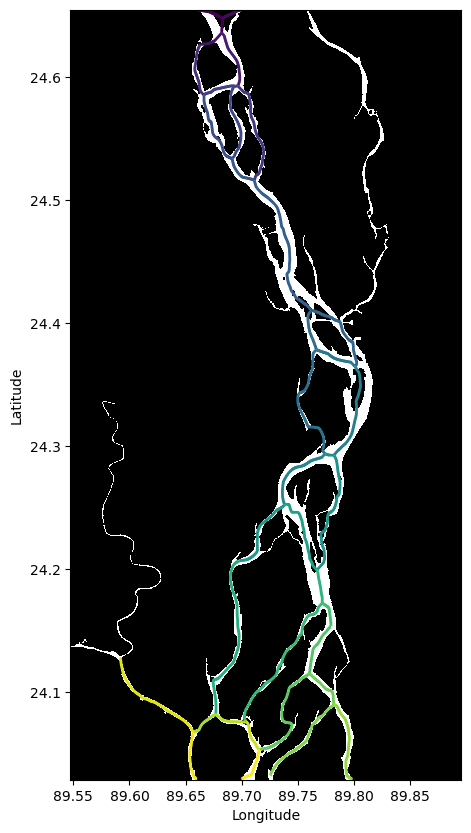

In [ ]:
cmap = plt.get_cmap('viridis')

braided_gdf['color'] = [cmap(i / (len(braided_gdf.branch_id) - 1)) for i in range(len(braided_gdf.branch_id))] if len(braided_gdf.branch_id) > 1 else [cmap(0.5)]

fig, ax = plt.subplots(figsize=(10, 10))
ax.pcolormesh(lon, lat, data, shading='auto', cmap='gray')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

braided_gdf.plot(ax=ax, color=braided_gdf.color, linewidth=2, label='generated CL')

x,757812.702814,757822.466792,757832.230769,757841.994747,757851.758724,757861.522701,757871.286679,757881.050656,757890.814634,757900.578611,...,794495.965858,794505.729836,794515.493813,794525.257791,794535.021768,794544.785745,794554.549723,794564.313700,794574.077678,794583.841655
y,,,,,,,,,,,,,,,,,,,,,
2.729803e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.729793e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.729783e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.729773e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.729764e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.659834e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.659824e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.659815e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


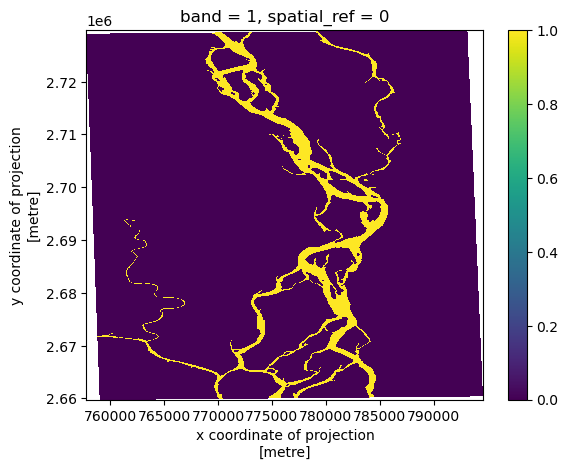

In [ ]:
import rioxarray

# import river mask from tif
path = r"..\data\brahmaputra\masks\figs\brahmaputra_2024-02-03_smoothed_mask.tif"
rds = rioxarray.open_rasterio(path)
rds_utm = rds.rio.reproject('EPSG:32645')
rds_utm.rio.to_raster(r"..\data\brahmaputra\masks\figs\brahmaputra_2024-02-03_smoothed_mask_UTM.tif")

rds_utm = rds_utm.where(rds_utm != 255)
rds_utm[0,:,:].plot.imshow()

df = rds_utm[0].to_pandas()
df


<Axes: >

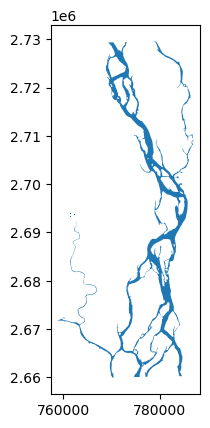

In [85]:
from shapely.geometry import shape

binary_mask = (rds_utm[0,:,:] > 0).values.astype(np.uint8)  # binary mask: water=1, else=0

# Get transform for the raster (important for spatial coordinates)
transform = rds_utm.rio.transform()

# Extract polygons from water mask raster
polygons = []
values = []

for geom, val in rasterio.features.shapes(binary_mask, transform=transform):
    if val == 1:  # water polygons only
        polygons.append(shape(geom))

water_gdf = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:32645')
water_gdf.plot()

Processing channel: 6
Processing channel: 7
Processing channel: 8
Processing channel: 9
Processing channel: 10


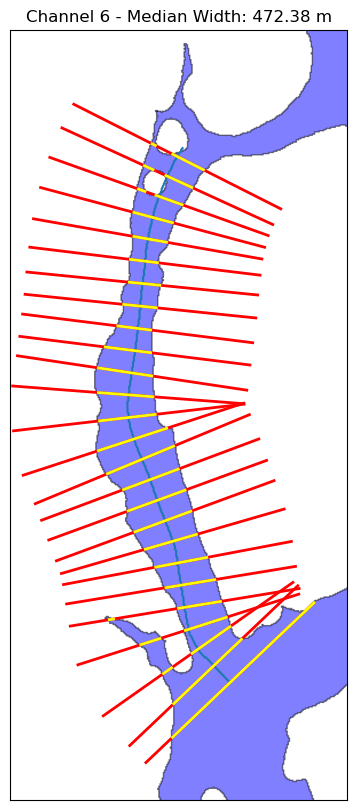

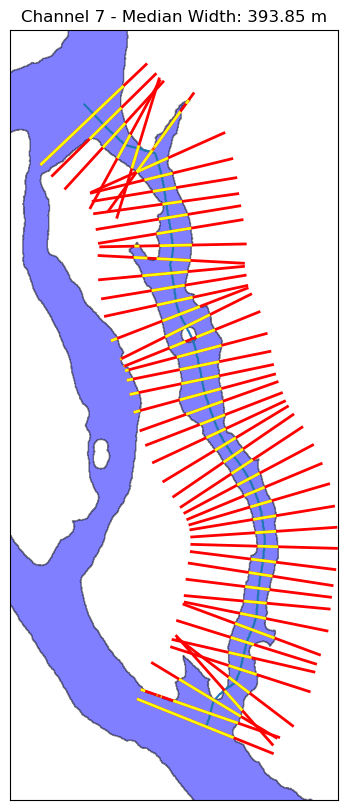

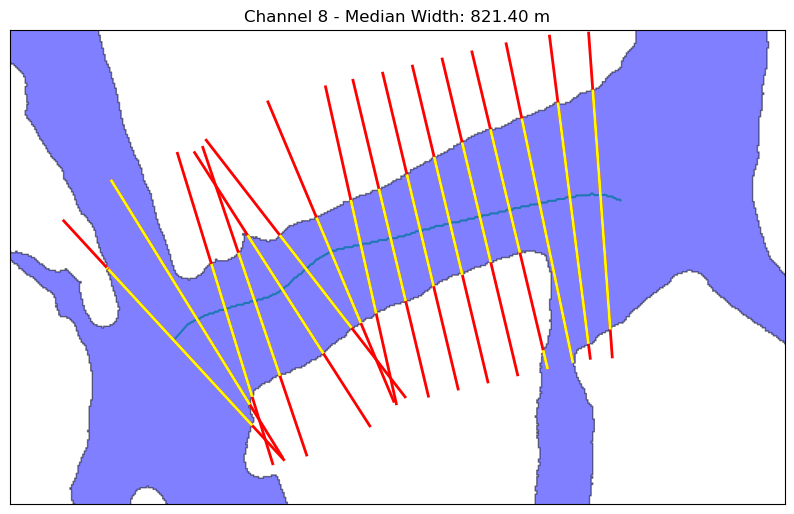

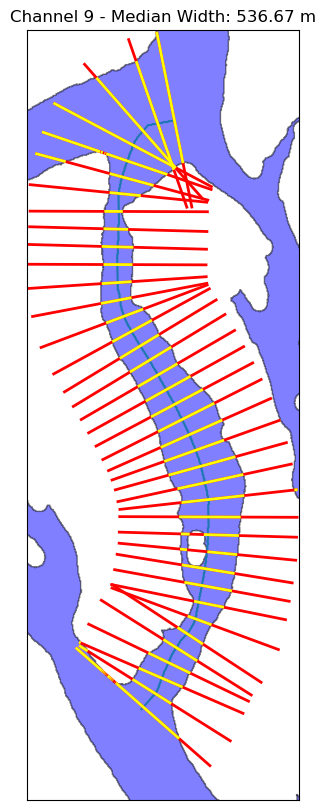

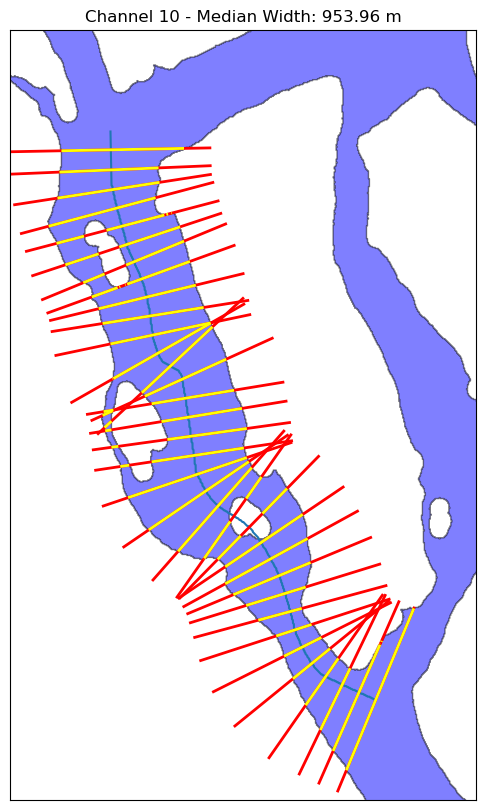

In [ ]:
# Create function to extract widths from the water mask and PIXC data
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Function from stack exchange: https://gis.stackexchange.com/questions/177583/interpolating-every-x-distance-along-line-in-shapely
def create_points(row, point_separation):
    # Can be used for many different linestrings!
    geom = row.geometry
    #For each geometry, create a point along it for each distance in the range from 0 to line length, with an interval
    point_list = [geom.interpolate(distance=x) for x in np.arange(start=0, stop=geom.length, step=point_separation)]
    return point_list

def calculate_vector_general(coord1, coord2):
    # Calculate the direction vector for a LineString at the given endpoint.
    vec = np.array(coord2) - np.array(coord1)
    return vec / np.linalg.norm(vec)  # Normalize


cl_gen = braided_gdf
hemi = 'north'
transect_len = 1000 # meters
theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c))) #2D rotation matrix

import rioxarray
rds = rioxarray.open_rasterio(tiff_path)
rds_utm = rds.rio.reproject('EPSG:32645')
# mask out 255 values (no data)
rds_utm = rds_utm.where(rds_utm != 255)
#rds_utm[0,:,:].plot.imshow()

# loop through each channel in braided_gdf
for channelID in cl_gen.branch_id[5:10]:
    print('Processing channel:',channelID)
    sel_channel = cl_gen.loc[cl_gen.branch_id == channelID]

    # convert to UTM
    centroid = sel_channel.geometry.unary_union.centroid
    utm_zone = int((centroid.x + 180) // 6) + 1
    if hemi == 'north':
        utm_crs = f'EPSG:{32600 + utm_zone}'
    elif hemi == 'south':
        utm_crs = f'EPSG:{32700 + utm_zone}'
    else:
        raise ValueError("Invalid hemisphere. Use 'north' or 'south'.")

    sel_channel_utm = sel_channel.to_crs(utm_crs)
    coords_list = list(sel_channel_utm.geometry.iloc[0].coords)
    x_coords = [x for x,y in coords_list]
    y_coords = [y for x,y in coords_list]

    # extract point locations every 100 m along the line
    sel_channel_utm["point_list"] = sel_channel_utm.apply(lambda x: create_points(row=x, point_separation=200), axis=1)
    
    #Create a point dataframe by exploding the point list into individual points/rows
    points_df = sel_channel_utm.explode(column="point_list")
    points_df = points_df.set_geometry("point_list").drop(columns="geometry").rename_geometry("geometry").set_crs(sel_channel_utm.crs)
    points_df = points_df.reset_index(drop=True)

    if len(points_df) <= 1:
        print('Channel contains only one point....skipping channel No. ',channelID)
        continue


    # Prepare Trimmed SWOT PIXC data for intersection with transects
    # gdf_buffered = pc.get_width_dependent_buffer(sel_cl_gdf,'EPSG:4326',hemi,buffer_width,cap_val='flat')

    # # Trim SWOT PIXC to buffer
    # clipped_gdf = gpd.clip(swot_gdf, gdf_buffered) # Use 'trimmed_gdf' to use water mask trimmed data
    # clipped_gdf = clipped_gdf.copy()

    # sub_swot = trim_to_one_channel(sel_channel, trimmed_pixc_gdf,hemi,tile_figdir,pixcdate,channelID,buffer_width=1000,savePlot=False) # Extracts SWOT data for one channel
    # sub_swot_utm = sub_swot.to_crs(utm_crs)

    # mpt = MultiPoint([shape(row['geometry']) for _, row in sub_swot_utm.iterrows()])
    # ratioval = 0.01
    # if float(sel_channel_utm.geometry.length) > 3000: # change ratio value for SWOT extent polygon determination based on selected channel reach length
    #     ratioval = 0.05

    # shapeout = shapely.concave_hull(mpt, ratio=ratioval,allow_holes=True)
    # swot_boundary = gpd.GeoDataFrame(geometry=[shapeout],crs=utm_crs)


    # save transects to a gdf for plotting
    transects_gdf = gpd.GeoDataFrame() # initialize dataframe
    intersects_gdf = gpd.GeoDataFrame() # initialize dataframe
    extract_polys = gpd.GeoDataFrame() # initialize dataframe
    riverSP_gdf_oneChannel = gpd.GeoDataFrame() # initialize dataframe for saving single channels

    #print('Extracting transects, widths and heights...')
    for idx in points_df.index:
        coord = list(points_df.geometry.iloc[idx].coords)
        if idx == 0:
            coord_b4 = coord
            coord_af = list(points_df.geometry.iloc[idx+1].coords)

        if idx == len(points_df.index) - 1:
            coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
            coord_af = coord


        if idx != len(points_df.index) - 1 and idx != 0:
            coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
            coord_af = list(points_df.geometry.iloc[idx+1].coords)

        coord_b4 = [coord_b4[0][0],coord_b4[0][1]]
        coord_af = [coord_af[0][0],coord_af[0][1]]

        # Compute vector and rotated vector
        vec = calculate_vector_general(coord_b4,coord_af)
        rot_vec = np.dot(vec, R)

        pt1 = np.array(coord) - transect_len*rot_vec
        pt2 = np.array(coord) + transect_len*rot_vec
        line = LineString([Point(pt1),Point(pt2)])

        # plot transect
        transect_temp = gpd.GeoDataFrame(geometry=[line],crs=points_df.crs)
        transect_temp['TID'] = idx  # Add transect ID
        transect_temp['branch_id'] = channelID  # Add branch ID
        transects_gdf = pd.concat([transects_gdf,transect_temp])


    # set transect index to TID
    transects_gdf.set_index('TID', inplace=True)
    intersect_rows = []

    for idx, row in transects_gdf.iterrows():
        intersects = water_gdf.intersection(row.geometry)
        intersects = [geom for geom in intersects if not geom.is_empty]

        if not intersects:
            transects_gdf.at[idx, 'width_S2'] = 0.0
            continue

        total_length = sum(geom.length for geom in intersects)
        transects_gdf.at[idx, 'width_S2'] = total_length

        # Store each intersecting line separately in intersects_gdf with reference to transect idx
        for geom in intersects:
            # Only keep LineStrings or MultiLineStrings
            if geom.geom_type == 'LineString':
                intersect_rows.append({'transect_idx': idx, 'geometry': geom})
            elif geom.geom_type == 'MultiLineString':
                for part in geom.geoms:
                    intersect_rows.append({'transect_idx': idx, 'geometry': part})

    # Create GeoDataFrame for intersections
    intersects_gdf = gpd.GeoDataFrame(intersect_rows, crs=transects_gdf.crs)
    intersects_gdf = intersects_gdf[intersects_gdf.is_empty == False]


    fig, ax = plt.subplots(figsize=(10, 10))
    sel_channel_utm.plot(ax=ax)
    water_gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
    # set axis limits to the extent of sel_channel_utm with 1 km buffer
    ax.set_xlim(sel_channel_utm.total_bounds[[0]] - 1000, sel_channel_utm.total_bounds[[2]] + 1000)
    ax.set_ylim(sel_channel_utm.total_bounds[[1]] - 1000, sel_channel_utm.total_bounds[[3]] + 1000)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    transects_gdf.plot(ax=ax, color='red', linewidth=2, alpha=1)
    intersects_gdf.plot(ax=ax, color='yellow', linewidth=2, alpha=1)
    ax.set_title(f'Channel {channelID} - Median Width: {transects_gdf["width_S2"].median():.2f} m')

    transects_gdf

In [151]:
transects_gdf.head(10)

,geometry,branch_id,width_S2
TID,,,
0,"LINESTRING (772289.646 2715060.054, 773058.595...",10,1745.200138
1,"LINESTRING (772102.242 2715138.323, 772908.078...",10,1169.225062
2,"LINESTRING (771905.637 2715229.503, 772772.422...",10,682.755883
3,"LINESTRING (771602.836 2715392.153, 772746.778...",10,567.589670
4,"LINESTRING (771260.252 2715711.003, 772811.887...",10,475.871194
5,"LINESTRING (771044.713 2716054.295, 772831.755...",10,415.245946
6,"LINESTRING (770917.201 2716366.775, 772819.126...",10,369.628794
7,"LINESTRING (770857.274 2716597.769, 772787.877...",10,447.708152
8,"LINESTRING (770814.705 2716743.28, 772725.334 ...",10,619.731327
